# Single mode squeezed state model with BS

Use the multihead (2-head) gates in the phase space 
to create a network that represent two single mode squeezed vacuum
by starting from a Gaussian state and making a pullback

The single mode squeezed state pass through a beams splitter



<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>


nonlinearxwaves@gmail.com<br>
@created 18 october 2020<br>
@version 23 septembre 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages

In [2]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
tf.keras.backend.clear_session()

In [4]:
np.set_printoptions(precision=2)

## Dimension (number of modes times 2)

In [5]:
N = 4

## Build vacuum by the Gaussian state

In [6]:
vacuum = ps.VacuumLayer(N)

## Single mode squeezer 1

In [7]:
ra=0.2;
phia=np.pi/4;

In [8]:
squeezer_a=ps.SingleModeSqueezerLayer(N, r_np=ra, theta_np=phia, n_squeezed=0, trainable=False)

## Single mode squeezer 2

In [9]:
rb=3.0;
phib=np.pi/3;
squeezer_b=ps.SingleModeSqueezerLayer(N, r_np=rb, theta_np=phib, n_squeezed=1, trainable=False)

## Beam splitter

In [10]:
theta=0.5 # maximum squeezing is for pi/4=0.78
phi0=0.0
phi1=0.0

In [11]:
bs = ps.BeamSplitterLayer(N, theta=theta, phi0=phi0, phi1=phi1, n_0=0, n_1=1,  trainable_theta=True)

# Build the model

In [12]:
xin = tf.keras.layers.Input(N)
x0,d0 = bs(xin)
x1, d1 = squeezer_b(x0,d0)
x2, d2 = squeezer_a(x1,d1)
chir, chii = vacuum(x2, d2)
squeezed1mBS = tf.keras.Model(inputs = xin, outputs=[chir, chii])

## Introduce an entanglement layer to maximize

In [13]:
cov_layer = ps.covariance(N)
cova, chii_x, _ = cov_layer(chir,chii, squeezed1mBS)
e_layer = ps.entanglementBSLayer(N)
delta, Edelta, ca = e_layer(cova)
entangler = tf.keras.Model(inputs = xin, outputs=delta)
entanglement_value = tf.keras.Model(inputs = xin, outputs=Edelta)
cov_entire = tf.keras.Model(inputs=xin, outputs= cova)
cov_reduced = tf.keras.Model(inputs=xin, outputs= ca)

### Dummy training points

In [14]:
Nbatch=10
gtarget=np.eye(N)
dtarget=2.4*np.ones((N,1))
xtrain = np.random.rand(Nbatch, N)-0.5
ytrain =np.zeros_like(xtrain)
dtrain = np.zeros((Nbatch,N))
gtrain = np.zeros((Nbatch,N,N))
for j in range(Nbatch):
    for i in range(N):
        dtrain[j,i]=dtarget[i]
        for k in range(N):
            gtrain[j,i,k]=gtarget[i,k]

In [15]:
entangler(xtrain)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5184047>

In [16]:
entanglement_value(xtrain)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5510576>

In [17]:
cov_reduced(xtrain)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 23.79, -40.38],
       [-40.38,  70.6 ]], dtype=float32)>

# Compare with theory

Define a python function to find the expected value of entanglement 

## Degree of entanglement and elements of the covariance matrix

In [18]:
def theory_value(ra,phia,rb,phib, theta,phi0,phi1):
    """ Return entanglement value following PRA66.064304 (note there is a mistake in the paper it is phi0-phi1)"""
    cha = np.math.cosh(ra)
    chb = np.math.cosh(rb)
    sha = np.math.sinh(ra)
    shb = np.math.sinh(rb)

    ct = np.math.cos(theta)
    st = np.math.sin(theta)


    xa = sha*cha
    xb = shb*chb

    Sa=cha**2+sha**2
    Sb=chb**2+shb**2

    Db = 2*phi1-phib
    Da = 2*phi0-phia

    DbDa=Db-Da
    tmp = np.math.cos(DbDa)


    m11  = Sa*ct**2+Sb*st**2+2*xa*ct**2*np.math.cos(Da)+2*xb*st**2*np.math.cos(Db)
    m12 = 2*xa*ct**2*np.math.sin(Da)+2*xb*st**2*np.math.sin(Db)
    m21 = m12
    m22 = Sa*ct**2+Sb*st**2-2*xa*ct**2*np.math.cos(Da)-2*xb*st**2*np.math.cos(Db)

    nu2 = m11*m22-m12*m21
    nu = 0.5*np.math.sqrt(nu2)

    EE=-np.math.log(2/(nu+1))-(nu-1)*0.5*np.math.log((nu-1)/(nu+1))


    return nu, EE, m11, m12, m21, m22

Values for  nu and E(nu) expected from theory

In [19]:
nuth, Eth, m11th, m12th, m21th, m22th =theory_value(ra,phia,rb,phib,theta,phi0,phi1)

In [20]:
nuth, Eth

(3.518400462775096, 1.5510563299760842)

In [21]:
m11th, m12th, m21th, m22th

(70.60215099433715, -40.37568768954344, -40.37568768954344, 23.791240068650314)

# Plot entanglement vs delta

In [22]:
def Edelta_np(dplot):
    Ed = -np.log(2/(dplot+1))-0.5*(dplot-1)*np.log((dplot-1)/(dplot+1))
    return Ed

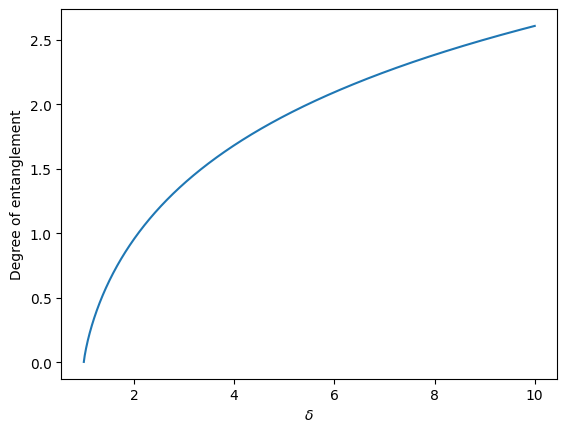

In [23]:
dplot=np.linspace(1.001,10,1000)
Edplot=Edelta_np(dplot)
plt.plot(dplot,Edplot)
plt.ylabel("Degree of entanglement");
plt.xlabel("$\delta$");

# Maximize entanglement

### Define a custom loss function for the entropy to be minimized

In [24]:
entangler.add_loss(-tf.math.log(Edelta))
entangler.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [25]:
entangler.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, 4)]                0             []                                      
                                                                                                                        
 beam_splitter_layer (BeamSplitterLaye  [(None, 4),               3             ['input_1[0][0]']                       
 r)                                     (4, 1)]                                                                         
                                                                                                                        
 single_mode_squeezer_layer_1 (SingleM  [(None, 4),               2             ['beam_splitter_layer[0][0]',           
 odeSqueezerLay

In [26]:
history = entangler.fit(x=xtrain,
                        y=ytrain,
                      epochs=1000,
                      verbose=0)

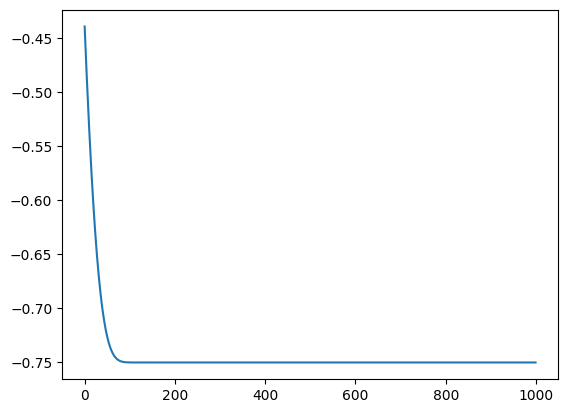

In [27]:
history.history.keys()
plt.plot(history.history['loss'])


In [28]:
# display the value of delta after training
entangler(xtrain)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1433086>

In [29]:
# display the value of the entanglement
entanglement_value(xtrain)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1177647>

In [30]:
cov_reduced(xtrain)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[181.25, -61.27],
       [-61.27,  21.54]], dtype=float32)>

In [31]:
cov_entire(xtrain)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 181.25,  -61.27, -180.5 ,   61.53],
       [ -61.27,   21.54,   61.52,  -20.14],
       [-180.5 ,   61.52,  181.25,  -61.28],
       [  61.53,  -20.14,  -61.28,   21.55]], dtype=float32)>

# Value of theta after maximization

In [32]:
bs.theta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7853984>

In [33]:
np.pi/4

0.7853981633974483

# Value of beam splitter phases 

In [34]:
bs.phi0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.71992713>

In [35]:
bs.phi1

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.7199696>

In [36]:
squeezer_a.r

<tf.Variable 'single_mode_squeezer_layer/r:0' shape=() dtype=float32, numpy=0.2>

In [37]:
squeezer_a.theta

<tf.Variable 'single_mode_squeezer_layer/theta:0' shape=() dtype=float32, numpy=0.7853982>

In [38]:
squeezer_b.theta

<tf.Variable 'single_mode_squeezer_layer_1/theta:0' shape=() dtype=float32, numpy=1.0471976>

In [39]:
squeezer_b.r

<tf.Variable 'single_mode_squeezer_layer_1/r:0' shape=() dtype=float32, numpy=3.0>

# For maximum entanglement the following quantity must be a multiple of pi 

In [40]:
2*(bs.phi1-bs.phi0)+squeezer_a.theta-squeezer_b.theta

<tf.Tensor: shape=(), dtype=float32, numpy=-3.1415927>

In [41]:
np.pi/2

1.5707963267948966

In [42]:
np.pi/4

0.7853981633974483